# Introduction

This is a weather history analysis in Szeged for the period from 2006 to 2016 

The dataset contains different columns which show that data were taken on hourly basis for the 10 years 

The dataset also includes both summary and daily summary features which are descriptive of the weather in each hour, where daily summary is giving more details about the weather of the day not specific to this hour, yet summary is summarizing this description in unique words.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading csv file and reading it
df = pd.read_csv('weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


# Exploratory Data Analysis (EDA)

### Data Cleaning

A step by step analysis would first start with a brief summary about the dataset features, correcting any typo in the column names, and allowing the columns names to be better interpreted.

Data cleaning wold also include converting dates to date time series if were not accurate, and exploring any anomalies in the type of values in the dataset.

We then start with dealing with missing data either by impputing or dropping based on the conditions of those missing data, and to deal with any data which are not logical.

In [3]:
#showing a brief summary about number of unique values in each column
df.nunique()

Formatted Date              96429
Summary                        27
Precip Type                     2
Temperature (C)              7574
Apparent Temperature (C)     8984
Humidity                       90
Wind Speed (km/h)            2484
Wind Bearing (degrees)        360
Visibility (km)               949
Loud Cover                      1
Pressure (millibars)         4979
Daily Summary                 214
dtype: int64

In [4]:
#correcting cloud cover name since it had a typo
df.rename(columns = {'Loud Cover':'Cloud Cover'}, inplace = True)
#converting datetime string to date
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'])

In [5]:
#identifying the size of the dataset we have
print('The size of the dataset is {} rows and {} features.'.format(df.shape[0], df.shape[1]))

The size of the dataset is 96453 rows and 12 features.


In [6]:
#determining type of each column in the dataset whether numerical or categorical
for idx, i in enumerate(df.dtypes):
    feature = df.dtypes.index[idx]
    if i == 'object':
        #using type function for the first element in the column to know its actual type
        print('class of {} feature is {}.' .format(feature, type(df[feature][0])))
    else:
        print('type of {} feature is {}.' .format(feature, i))
print("-"*60)
#Total number of numerical and categorical features
print('There are {} numerical features and {} categorical features'.format((df.dtypes).value_counts()[0], (df.dtypes).value_counts()[1]))

#changing headers into lower case letters, stripping spaces and replacing space with _ to better call them
df.rename(columns = (lambda x: x.strip().lower().replace(" ","_")), inplace=True);
print("-"*60)
#showing both numerical and categorical features
print('Numerical Features are {}' .format(df.select_dtypes('number').columns))
print("-"*60)
print('Categorical Features are {}' .format(df.select_dtypes(exclude = 'number').columns))

class of Formatted Date feature is <class 'datetime.datetime'>.
class of Summary feature is <class 'str'>.
class of Precip Type feature is <class 'str'>.
type of Temperature (C) feature is float64.
type of Apparent Temperature (C) feature is float64.
type of Humidity feature is float64.
type of Wind Speed (km/h) feature is float64.
type of Wind Bearing (degrees) feature is float64.
type of Visibility (km) feature is float64.
type of Cloud Cover feature is float64.
type of Pressure (millibars) feature is float64.
class of Daily Summary feature is <class 'str'>.
------------------------------------------------------------
There are 8 numerical features and 4 categorical features
------------------------------------------------------------
Numerical Features are Index(['temperature_(c)', 'apparent_temperature_(c)', 'humidity',
       'wind_speed_(km/h)', 'wind_bearing_(degrees)', 'visibility_(km)',
       'cloud_cover', 'pressure_(millibars)'],
      dtype='object')
----------------------

In [7]:
#showing the type of each column as well as the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
formatted_date              96453 non-null object
summary                     96453 non-null object
precip_type                 95936 non-null object
temperature_(c)             96453 non-null float64
apparent_temperature_(c)    96453 non-null float64
humidity                    96453 non-null float64
wind_speed_(km/h)           96453 non-null float64
wind_bearing_(degrees)      96453 non-null float64
visibility_(km)             96453 non-null float64
cloud_cover                 96453 non-null float64
pressure_(millibars)        96453 non-null float64
daily_summary               96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [8]:
#identifying the missing data that have at leaset one missing value
missing_data = df.isnull().sum()
missing_data = (missing_data[missing_data> 0])
print('The missing data of {} feature is {:.2f} %'.format(missing_data.index[0],(missing_data[0]/df.shape[0])*100))

The missing data of precip_type feature is 0.54 %


In [9]:
#we can then drop those missing data since they are little so elimination saves time that might be 
#used in data imputation, as well as it is not preferred to impute data that i might use in prediction
df.dropna(inplace=True)
#figuring out any missing data after elimination
print('There is {} missing data after cleaning errors' .format(df.isnull().any().sum()))

There is 0 missing data after cleaning errors


In [10]:
#doing describtive statistics
df.describe()

,temperature_(c),apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),cloud_cover,pressure_(millibars)
count,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.000000,95936.0,95936.000000
mean,11.940976,10.862531,0.734841,10.804936,187.518773,10.362402,0.0,1003.150038
std,9.570671,10.717812,0.195724,6.920727,107.385351,4.173780,0.0,117.276976
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.604167,2.276389,0.600000,5.796000,116.000000,8.372000,0.0,1011.890000
50%,12.033333,12.033333,0.780000,9.933700,180.000000,10.046400,0.0,1016.420000
75%,18.844444,18.844444,0.890000,14.135800,290.000000,14.812000,0.0,1021.050000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [11]:
# we now show the main statistical charactersitics of the datset that were not shown in the built-in
#function of describe
Mode=[]
IQR=[]
Skewness=[]
Kurtosis=[]
Range = []
#we made the columns excluding the first column of Years because it does not make sense to calculate statistics for it
for column in df.select_dtypes('number').columns[:]:
    Mode.append(np.round(df[column].mode().iat[0],2))    
    IQR.append(np.round(df[column].quantile(0.75)-df[column].quantile(0.25),2))
    Skewness.append(np.round(df[column].skew(),2))
    Kurtosis.append(np.round(df[column].kurt(),2))
    Range.append(np.round(df[column].max()-df[column].min()))
stats_data = [Mode, IQR, Skewness, Kurtosis, Range]
col_names = ['temperature_(c)','apparent_temperature_(c)','humidity','wind_speed_(km/h)','wind_bearing_(degrees)','visibility_(km)','loud_cover','pressure_(millibars)']
#we now set a dataframe that will include all those statistical data
#we set the column names
stat_cols = ['Mode','IQR','Skewness','Kurtosis', 'Range']
#we set the index column and the columns data
#we set new names excluding first name of years
descriptive_statistics = pd.DataFrame(stats_data, columns = col_names).set_index([stat_cols])
descriptive_statistics

,temperature_(c),apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),loud_cover,pressure_(millibars)
Mode,7.22,12.78,0.93,3.22,0.00,9.98,0.0,0.00
IQR,14.24,16.57,0.29,8.34,174.00,6.44,0.0,9.16
Skewness,0.09,-0.06,-0.72,1.12,-0.15,-0.49,0.0,-8.40
Kurtosis,-0.57,-0.71,-0.47,1.77,-1.13,-0.27,0.0,68.88
Range,62.00,67.00,1.00,64.00,359.00,16.00,0.0,1046.00


In [12]:
#since the minimum air pressure that humans can withstand is 61.8 millibars, then we replace any value
#less than 61.8 by the minimum of 61.8
df['pressure_(millibars)'][df['pressure_(millibars)']<61.8] = 61.8

In [13]:
#since we note that loud cover column has constant value of zero, we tend to drop it
df.drop('cloud_cover', axis =1, inplace = True)

In [14]:
df.round(2).head()

,formatted_date,summary,precip_type,temperature_(c),apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),pressure_(millibars),daily_summary
0,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.47,7.39,0.89,14.12,251.0,15.83,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.36,7.23,0.86,14.26,259.0,15.83,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.38,9.38,0.89,3.93,204.0,14.96,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00+02:00,Partly Cloudy,rain,8.29,5.94,0.83,14.10,269.0,15.83,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00+02:00,Mostly Cloudy,rain,8.76,6.98,0.83,11.04,259.0,15.83,1016.51,Partly cloudy throughout the day.


### Exploratory Data Visualization

Exporatory visualization gives us insights about the dataset which would be easier to interpret and would help in quickly identifying any issue with the dataset.

Since our dataset includes both numerical and categorical data, we need to identify both and then start on plotting them

For categorical data, if they are many, we can exclude the most less contributing data of them (here I used data contributing less than 5% ) as others, which would make plotting easier.

We can define some functions that would save us time of repeating, and finally we would plot scatter plot of all features to visualize

In [15]:
#selecting numerical and categorical columns in the dataset
numerical_features = df.select_dtypes('number')
categorical_features = df.select_dtypes(exclude = 'number')
#dropping date time from categorical data
categorical_features.drop('formatted_date', axis=1, inplace=True)

In [16]:
#showing unique values in each of the categrical features
categorical_features.nunique()

summary           27
precip_type        2
daily_summary    214
dtype: int64

In [17]:
#making a copy of the categorical dataset
cat_feat_plot = categorical_features.copy()
#dropping daily summary since it is descriptive data
cat_feat_plot.drop('daily_summary', axis=1, inplace=True)

#looping into columns to replace any value in the column with contribution less than 5% with 'others'
for col in cat_feat_plot.columns:
    for perc in cat_feat_plot[col].value_counts(1):
        if perc < 0.05:
            name = cat_feat_plot[col].value_counts(1).index[cat_feat_plot[col].value_counts(1) == perc].tolist()[0]
            cat_feat_plot.loc[cat_feat_plot[col] == name, col] = 'others'
        else:
            continue

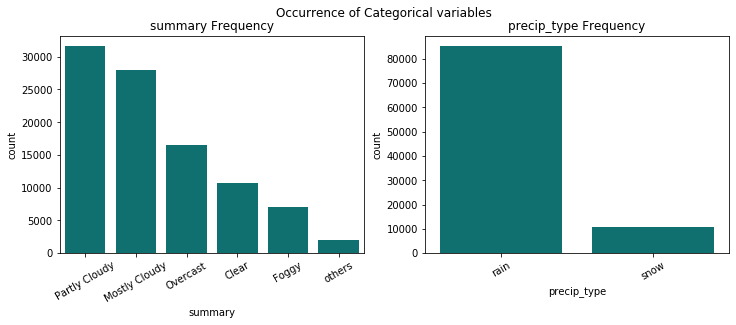

In [18]:
#Uni variate distribution of categorical data
#plotting frequency of occurrence for each column
fig = plt.figure(figsize = (12,4))
for i, col in enumerate(cat_feat_plot.columns):
    fig.add_subplot(1, 2, i+1)
    sns.countplot(data = cat_feat_plot, x = col, color='teal', order = cat_feat_plot[col].value_counts().index)
    plt.xticks(rotation = 30)
    plt.title(col + ' Frequency')
    plt.suptitle("Occurrence of Categorical variables")

In [19]:
#defining a function to plot and iterate through numerical features in the dataset for
#exploratory visualization
def plot_chart_exploratory(data, plot_function, row, cols):
    fig = plt.figure(figsize = (15,10))
    for i in range(len(data.columns)):
        fig.add_subplot(row, cols, i+1)
        plot_function(numerical_features.iloc[:,i], color='teal')
        plt.xlabel(numerical_features.columns[i])

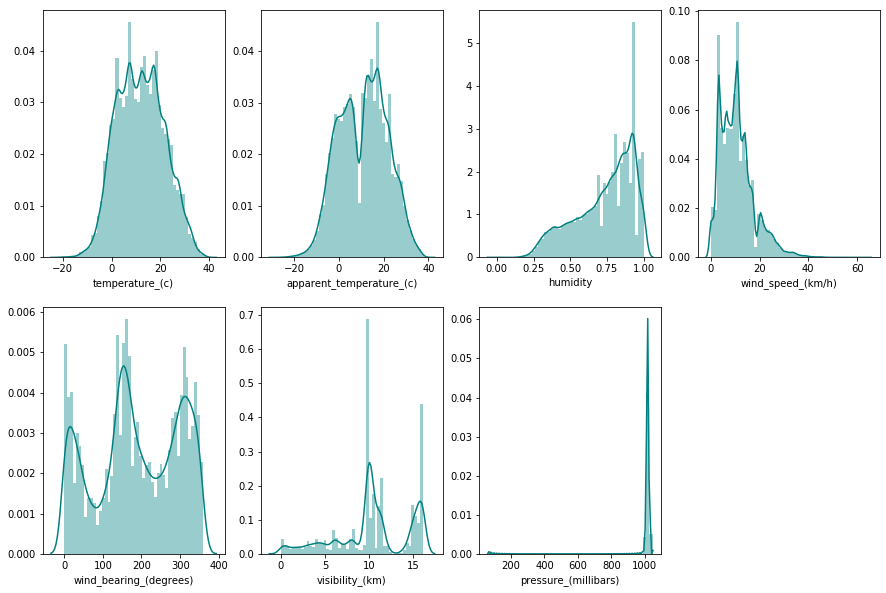

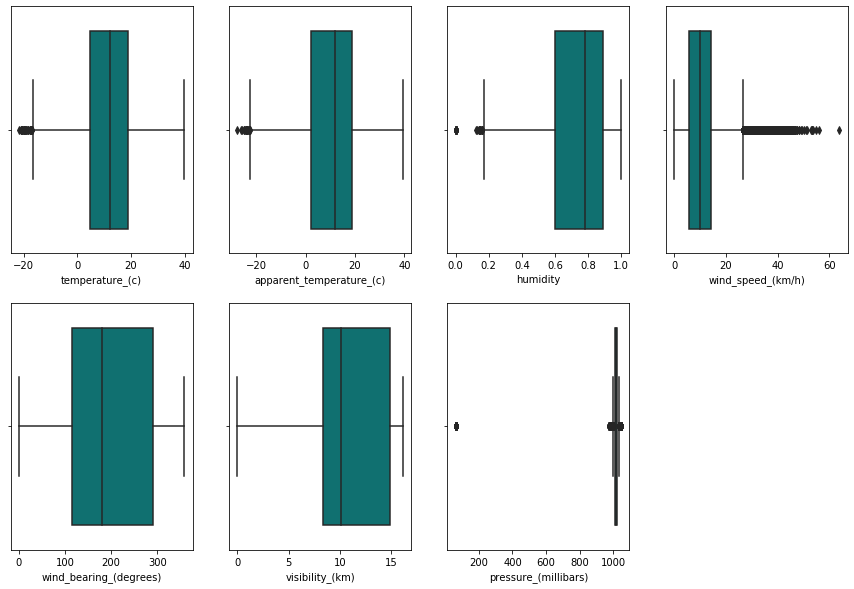

In [20]:
#Uni variate exploratory visualization to identify the properties of each numerical feature
#plotting distribution of each feature
plot_chart_exploratory(numerical_features, sns.distplot, 2, 4)
#plotting boxplot to identify outliers
plot_chart_exploratory(numerical_features, sns.boxplot, 2, 4)

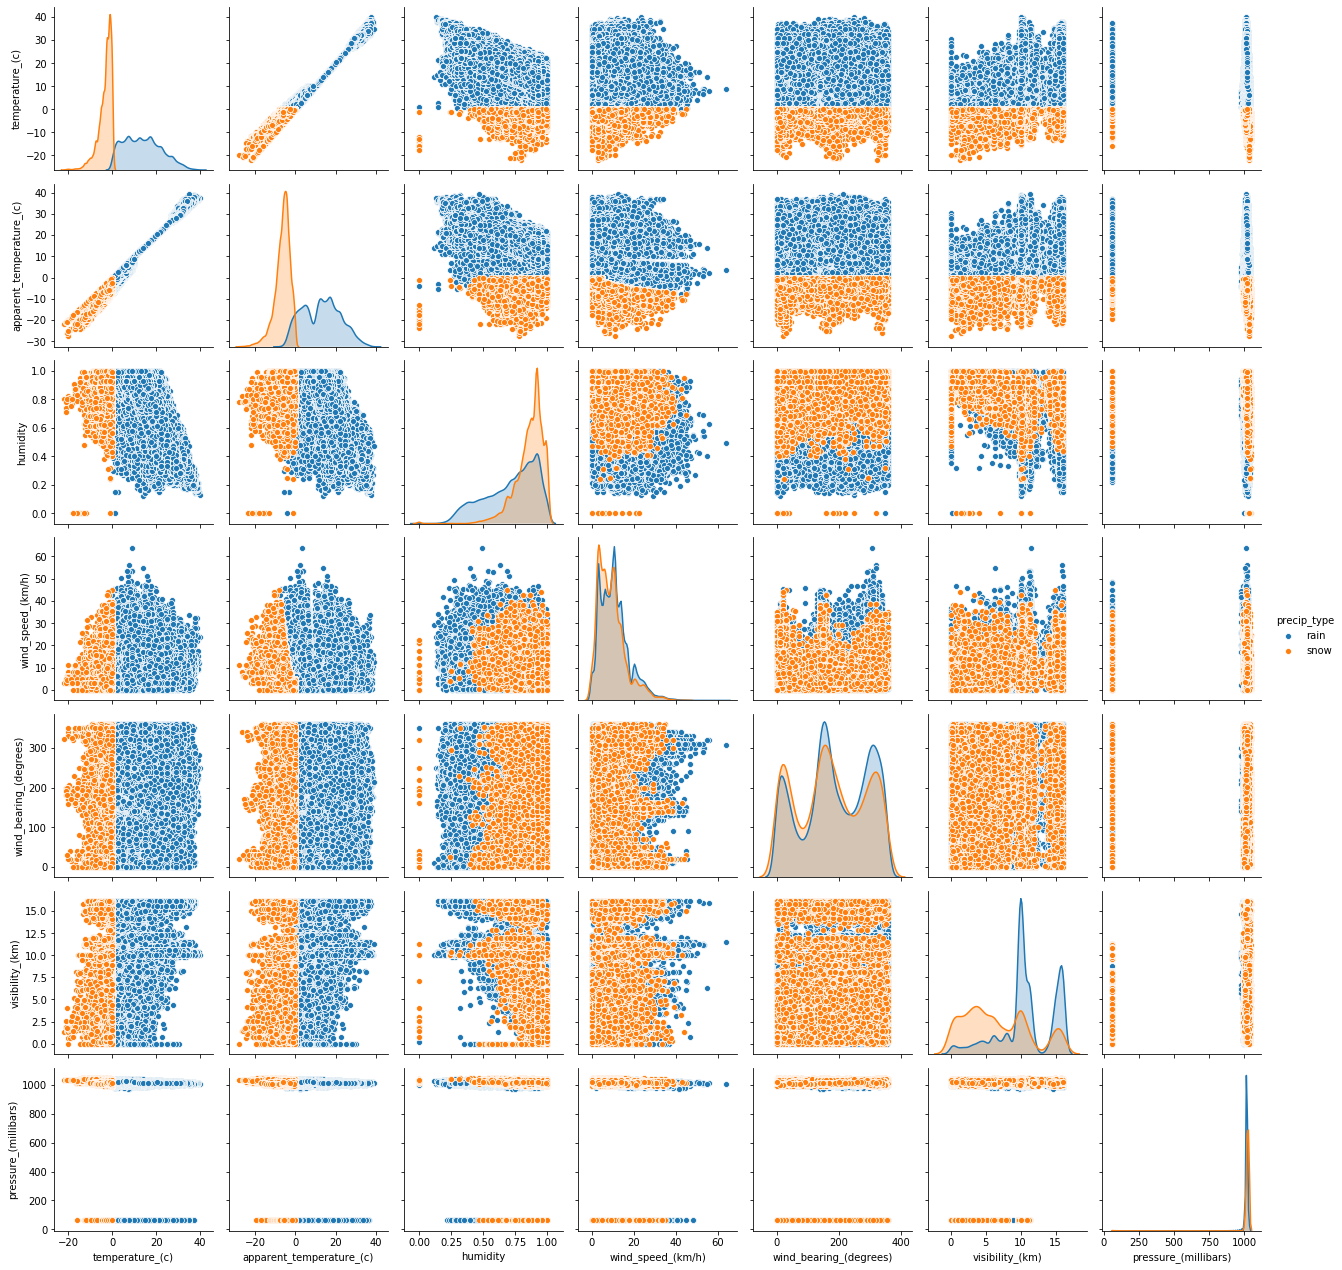

In [21]:
#plotting scatterplot matrix as primary visualization for the dataset
#Multi variate plotting with precip_type as unique
sns.pairplot(df, hue="precip_type");

### Dealing with Outliers

To remove outilers based on the gaussian concept, we need the features to be normally distributed, which is not true for all features here, so then I decided to drop the outliers based on extreme boundaries, so that we keep the size of the dataset almost the same (>95%).

For some features which can be converted to boolean, we do it to better use it in the future functions or predictions.

We then need to identify the correlation matrix between the different variables, to find out the strongly dependent factors to avoid multicollinearity and to identfy which strongly dependent feature to drop

In [22]:
#Replacing outliers with the upper and lower boundaries
print('The original size of dataset is {}'.format(df.shape[0]))
for col in numerical_features.columns:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    upper = df[col].quantile(0.75) + 3 * IQR
    lower = df[col].quantile(0.25) - 3 * IQR
    print( 'upper limit for {} is {:.2f}'.format(col,upper))
    print( 'lower limit for {} is {:.2f}'.format(col,lower))
    df.drop(df[df[col]<lower].index, inplace= True)
    df.drop(df[df[col]>upper].index, inplace= True)
print("-"*40)
print('Outliers are successfully replaced with the the boundaries set')
print("."*20)
print("."*20)
print('The new size of dataset is {}'.format(df.shape[0]))

The original size of dataset is 95936
upper limit for temperature_(c) is 61.57
lower limit for temperature_(c) is -38.12
upper limit for apparent_temperature_(c) is 68.55
lower limit for apparent_temperature_(c) is -47.43
upper limit for humidity is 1.76
lower limit for humidity is -0.27
upper limit for wind_speed_(km/h) is 39.16
lower limit for wind_speed_(km/h) is -19.22
upper limit for wind_bearing_(degrees) is 815.00
lower limit for wind_bearing_(degrees) is -410.00
upper limit for visibility_(km) is 34.18
lower limit for visibility_(km) is -11.01
upper limit for pressure_(millibars) is 1048.54
lower limit for pressure_(millibars) is 984.42
----------------------------------------
Outliers are successfully replaced with the the boundaries set
....................
....................
The new size of dataset is 94434


In [23]:
#since precip_type is our label, we convert it to boolean
df['precip_type'][df['precip_type'] == 'rain'] = 0
df['precip_type'][df['precip_type'] == 'snow'] = 1
df['precip_type'] = df['precip_type'].astype(int);

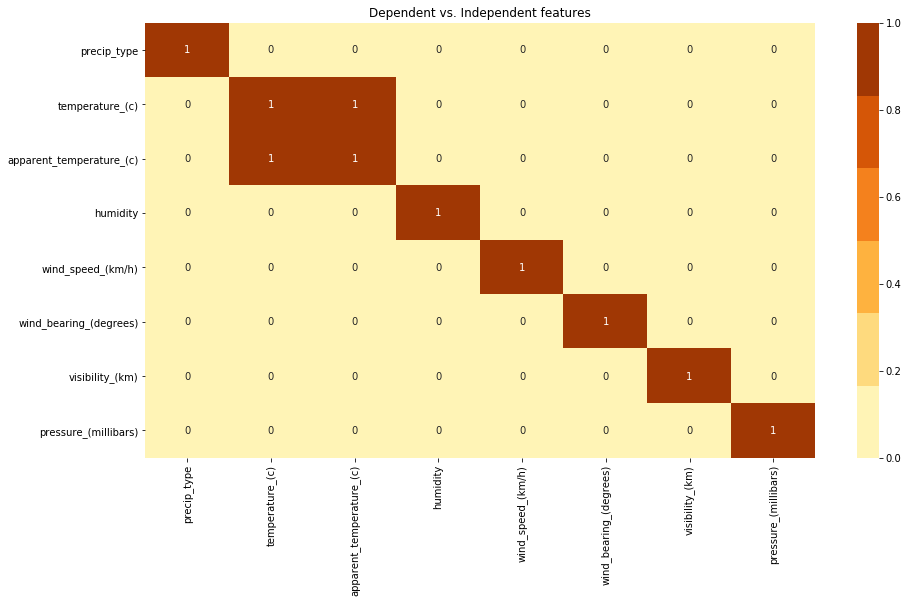

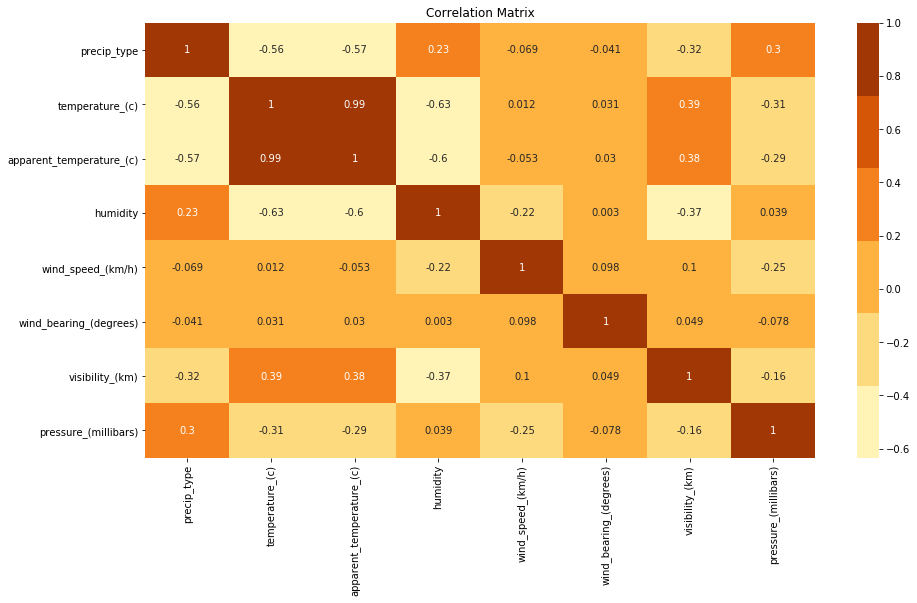

In [24]:
#making correlation between variables to eliminiate dependent variables
correlation = df.corr()
#shwoing boolean values if correlation is higher than 0.9 only as 1
cmap = sns.color_palette("YlOrBr")
plt.figure(figsize=(15,8))
sns.heatmap(correlation>0.9, annot = True, cmap=cmap);
plt.title('Dependent vs. Independent features');
plt.figure(figsize=(15,8))
sns.heatmap(correlation, annot = True, cmap=cmap);
plt.title('Correlation Matrix');

In [25]:
#to determine which column to drop from the dependent features, we see their correlation to our target
correlation.precip_type.abs().sort_values(ascending = False)

precip_type                 1.000000
apparent_temperature_(c)    0.566059
temperature_(c)             0.563529
visibility_(km)             0.317852
pressure_(millibars)        0.301717
humidity                    0.234060
wind_speed_(km/h)           0.069014
wind_bearing_(degrees)      0.041174
Name: precip_type, dtype: float64

In [26]:
#we drop the dependent feature as well as daily summary since it is descriptive and summary represnts it
df.drop(['temperature_(c)', 'daily_summary'], axis=1, inplace = True)
df.round(2).head()

,formatted_date,summary,precip_type,apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),pressure_(millibars)
0,2006-04-01 00:00:00+02:00,Partly Cloudy,0,7.39,0.89,14.12,251.0,15.83,1015.13
1,2006-04-01 01:00:00+02:00,Partly Cloudy,0,7.23,0.86,14.26,259.0,15.83,1015.63
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,0,9.38,0.89,3.93,204.0,14.96,1015.94
3,2006-04-01 03:00:00+02:00,Partly Cloudy,0,5.94,0.83,14.10,269.0,15.83,1016.41
4,2006-04-01 04:00:00+02:00,Mostly Cloudy,0,6.98,0.83,11.04,259.0,15.83,1016.51


In [27]:
df.summary.value_counts()

Partly Cloudy               31513
Mostly Cloudy               27777
Overcast                    16353
Clear                       10035
Foggy                        7019
Breezy and Overcast           509
Breezy and Mostly Cloudy      489
Breezy and Partly Cloudy      363
Dry and Partly Cloudy          86
Light Rain                     63
Humid and Mostly Cloudy        40
Drizzle                        39
Breezy and Foggy               35
Dry                            34
Breezy                         30
Humid and Partly Cloudy        17
Dry and Mostly Cloudy          14
Rain                           10
Humid and Overcast              7
Breezy and Dry                  1
Name: summary, dtype: int64

In [28]:
#making a new column of summary weather that has specific unique values
df['weather_summary'] = np.select([df.summary.str.contains('Cloudy'), df.summary.str.contains('Overcast'),
                          df.summary.str.contains('Clear'), df.summary.str.contains('Foggy'), df.summary.str.contains('Breezy')],
                         ['cloudy','overcast','clear','foggy', 'breezy'], default = 'others')
df.drop('summary', axis = 1, inplace = True)

In [29]:
df.head()

,formatted_date,precip_type,apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),pressure_(millibars),weather_summary
0,2006-04-01 00:00:00+02:00,0,7.388889,0.89,14.1197,251.0,15.8263,1015.13,cloudy
1,2006-04-01 01:00:00+02:00,0,7.227778,0.86,14.2646,259.0,15.8263,1015.63,cloudy
2,2006-04-01 02:00:00+02:00,0,9.377778,0.89,3.9284,204.0,14.9569,1015.94,cloudy
3,2006-04-01 03:00:00+02:00,0,5.944444,0.83,14.1036,269.0,15.8263,1016.41,cloudy
4,2006-04-01 04:00:00+02:00,0,6.977778,0.83,11.0446,259.0,15.8263,1016.51,cloudy


# Fitting a Model and Prediction

### 1- Building a model using statsmodels library of statistics

we would set the model for both single feature and multi features, we can evaluate the results from the output which usually would include R2-score and p_vale and many different statistical data

In [30]:
#fitting a linear regression model for humidity and apparent temperature
df_regression = df.copy()
#dropping date timeseries column to use dataset in fitting a model
df_regression.drop('formatted_date', axis = 1, inplace = True)
df_regression_one_variable = df_regression.loc[:,['apparent_temperature_(c)', 'humidity']]
#making intercept column
df_regression_one_variable['intercept'] = 1
lm = sm.OLS(df_regression_one_variable['apparent_temperature_(c)'], df_regression_one_variable[['humidity','intercept']])
#fitting the model
results = lm.fit();
results.summary(), results.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                OLS Regression Results                               
 Dep. Variable:     apparent_temperature_(c)   R-squared:                       0.365
 Model:                                  OLS   Adj. R-squared:                  0.365
 Method:                       Least Squares   F-statistic:                 5.431e+04
 Date:                      Sat, 02 Jan 2021   Prob (F-statistic):               0.00
 Time:                              14:10:58   Log-Likelihood:            -3.3647e+05
 No. Observations:                     94434   AIC:                         6.729e+05
 Df Residuals:                         94432   BIC:                         6.730e+05
 Df Model:                                 1                                         
 Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------

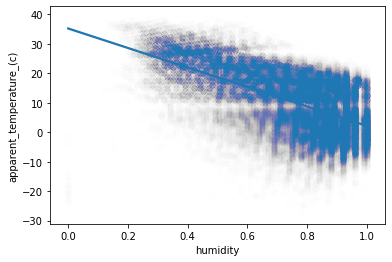

In [31]:
#showing relationship between dependent and independent variable as apparent temp is function of humidity
sns.regplot(data = df, x = df['humidity'], y = df['apparent_temperature_(c)'], scatter_kws={'alpha':0.005});

In [32]:
#fitting a linear regression model for humidity, wind speed and precip type and apparent temperature
df_regression_multi_variable = df_regression[['apparent_temperature_(c)', 'humidity', 'wind_speed_(km/h)', 'precip_type']]
#making intercept column
df_regression_multi_variable['intercept'] = 1
lm_multi = sm.OLS(df_regression_multi_variable['apparent_temperature_(c)'], df_regression_multi_variable[['humidity','wind_speed_(km/h)','precip_type', 'intercept']])
#fitting the model
results_multi = lm_multi.fit()
results_multi.summary(), results_multi.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                OLS Regression Results                               
 Dep. Variable:     apparent_temperature_(c)   R-squared:                       0.596
 Model:                                  OLS   Adj. R-squared:                  0.596
 Method:                       Least Squares   F-statistic:                 4.645e+04
 Date:                      Sat, 02 Jan 2021   Prob (F-statistic):               0.00
 Time:                              14:11:13   Log-Likelihood:            -3.1512e+05
 No. Observations:                     94434   AIC:                         6.302e+05
 Df Residuals:                         94430   BIC:                         6.303e+05
 Df Model:                                 3                                         
 Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
 --

### 2- Prediction using Scikit-learn Library

We would need to first do one hot encoder for categorical feature that can't be binary encoded so that new columns are presented each with binary values.

we would then try different linear regression techniques and identify the scoring metrics of each model to identify which one would best fit so that we can approve it.

In [33]:
#doing one hot encoding to convert categorical values into numerical to use in uilding model
ohc = OneHotEncoder()
new_data = ohc.fit_transform(df_regression[['weather_summary']])
cats = ohc.categories_
new_cols = ['_'.join(['weather', cat]) for cat in cats[0]]
new_df = pd.DataFrame(new_data.toarray(), columns = new_cols)
#resetting index to avoid increased number of rows after concating
df_regression.reset_index(drop=True, inplace=True)
new_df.reset_index(drop=True, inplace=True)
df_regression_ohc = pd.concat([df_regression, new_df], axis=1)
df_regression_ohc.drop('weather_summary', axis=1, inplace = True)
df_regression_ohc.round(2).head()

,precip_type,apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),pressure_(millibars),weather_breezy,weather_clear,weather_cloudy,weather_foggy,weather_others,weather_overcast
0,0,7.39,0.89,14.12,251.0,15.83,1015.13,0.0,0.0,1.0,0.0,0.0,0.0
1,0,7.23,0.86,14.26,259.0,15.83,1015.63,0.0,0.0,1.0,0.0,0.0,0.0
2,0,9.38,0.89,3.93,204.0,14.96,1015.94,0.0,0.0,1.0,0.0,0.0,0.0
3,0,5.94,0.83,14.10,269.0,15.83,1016.41,0.0,0.0,1.0,0.0,0.0,0.0
4,0,6.98,0.83,11.04,259.0,15.83,1016.51,0.0,0.0,1.0,0.0,0.0,0.0


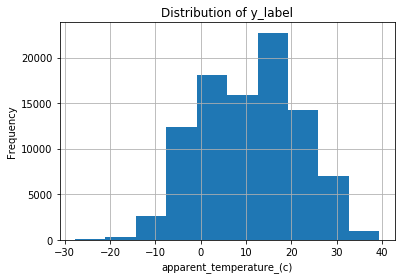

In [34]:
#since linear regression asumes normally distributed residuals, we then need to explore whether
#the y_values of 'apparent temperature' to be predicted is normally distributed or not
df_regression_ohc['apparent_temperature_(c)'].hist();
plt.xlabel('apparent_temperature_(c)')
plt.ylabel('Frequency')
plt.title('Distribution of y_label');

In [35]:
y_col = 'apparent_temperature_(c)'
X = df_regression_ohc.drop(y_col, axis = 1)
y = df_regression_ohc[y_col]
features = [x for x in df_regression_ohc.columns if x!= y_col]
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3)
#scaling the data we have as:
X_train_scaled = StandardScaler().fit(X_train)
X_test_scaled = StandardScaler().fit(X_test)
#fitting the model with different regularization factors
alphas = [0.0001, 0.005, 0.001, 0.1, 1 , 5, 10, 50, 100]
#applying the model through many types of linear regression
ridge = RidgeCV(alphas = alphas, cv=4).fit(X_train, y_train)
lasso = LassoCV(alphas = alphas, max_iter = 4, cv=4).fit(X_train, y_train)
elastic = ElasticNetCV(alphas = alphas, l1_ratio = np.linspace(0.1,0.9,9), max_iter=4).fit(X_train, y_train)
lm = LinearRegression().fit(X_train, y_train)

#Scoring metrics
r2_score_train = []
r2_score_test = []
rmse_score = []
Reression_cols = [lm, ridge, lasso, elastic]
for regression in Reression_cols:
    y_train_pred = regression.predict(X_train)
    y_pred = regression.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_pred)
    rmse = mean_squared_error (y_test, y_pred)
    r2_score_train.append(r2_train)
    r2_score_test.append(r2_test)
    rmse_score.append(rmse)
scoring_data = [r2_score_train, r2_score_test, rmse_score]
scoring_index = ['r2_score_train', 'r2_score_test', 'rmse_score']
col_names = ['lm', 'ridge', 'lasso', 'elastic']
scoring_metrics = pd.DataFrame(scoring_data, columns = col_names).set_index([scoring_index])
scoring_metrics

,lm,ridge,lasso,elastic
r2_score_train,0.647011,0.647011,0.646940,0.646925
r2_score_test,0.631823,0.631827,0.631884,0.631885
rmse_score,41.631732,41.631271,41.624799,41.624712


# Conclusion

*Q1: What is the state of weather usually in Szeged?*

Answer: \
From the graphs generated, we can figure out that it is usually cloudy either partly or mostly! so it has the highest probability. \
As well, it is most likely to rain on any day in the year than it to snow.

*Q2: Are the weather conditions usually normal?*
Answer: \
We can see that temperature is usually normal and ranging around 0-20 degrees, while humidity is highly skewed to 1, wind speed is highly skewed to low.

*Q3: Is there strong relationship between humidity, visibility and temperature?*
Answer: \
it is shown that temperature is inversily proportional to temperature while visibility is not much affected, so we can't predict visibility only based on temperature or humidity, there are other factors to be included. \ 
Also, from the statistics models, we can see that prediction accuracy is enhanced when we included many more features than only one feature, almost x1.5 better performance

*Q4: Could we use this dataset to predict the apparent temperature accurately?*
Answer: \
We have already built a model with linear regression techniques, and we can find out that the scoring accuracy of the model is 65% which is not high, so we may need to perform other machine learning techiques such as SVM.